# Pinksy-Rinzel Two Compartment Model #
Simulate the two compartment version of the Pinksy-Rinzel model

Matthias Heinkenschloss, Dept. of Computational Applied Mathematics and Operations Research, Rice University.
October 25, 2022.

Arjun, October 25, 2022: Added 2 compartment model constants (including parameters taken to be constants for now), functions for the gating variables s, c, q and for Ca, relevant 2 compartment ODEs. 

Arjun, October 26, 2022: Tested RK45, RK23, DOP853, Radau, BDF, LSODA as methods for solve_ivp. All yielded the same output graph. DOP853 had a runtime error for t_span = [0, 200] and was run for t_span = [0, 50].

References
-  Pinsky, P.~F. and Rinzel, J. (1994).
   Intrinsic and network rhythmogenesis in a reduced Traub model for CA3 neurons.
   {\em Journal of Computational Neuroscience}, 1(1):39--60, 
   https://doi.org/10.1007/BF00962717 .
-  Pinsky, P.~F. and Rinzel, J. (1995).
    Erratum: Intrinsic and network rhythmogenesis in a reduced Traub model for CA3 neurons.
    {\em Journal of Computational Neuroscience}, 2(3):275--275, 
    https://doi.org/10.1007/BF00961439 .

In [1]:
import numpy as np
import scipy.io as spio
from scipy.integrate import solve_ivp
##%matplotlib noteboo
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rcParams['font.size'] = 24
rc('font', family='sans-serif')
rcParams['font.family'] = 'Serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = True
import random

In [2]:
# Pinsky-Rinzel Model
#constants
Cm = 3    # Membrane Capcitance uF/cm^2
#dt = 0.05 # Time Step ms
p = 0.5   # Fraction of cable length assigned to soma (1-p for dendtrite)
Is = 0.25 # External Current Applied #can be -0.5 for simpler model
VNa = 120 # mv Na reversal potential
VK = -15  # mv K reversal potential
VL = 0    # mv Leakage reversal potential
VCa = 140 #
Vsyn = 60 #
Id = 0    #

#parameters taken as constants for now
gNa = 30.0  # mS/cm^2 Na max conductance 
gKDR = 15.0 # mS/cm^2 K max conductance 
gL = 0.1    # mS/cm^2 Leakage max conductance 
gCa = 10.0  # mS/cm^2 
gKAHP = 0.8 # mS/cm^2
gKC = 15.0  # mS/cm^2
gc = 2.1    # mS/cm^2

#Functions
#forward rate constant for fast sodium
def am(Vs):
    return 0.32*(13.1-Vs)/(np.exp((13.1-Vs)/4.0)-1.0)

#backward rate constant for fast sodium
def bm(Vs):
    return 0.28*(Vs-40.1)/(np.exp((Vs-40.1)/5.0)-1.0)

#forward rate constant for DR activation
def an(Vs):
    return 0.016*(35.1-Vs)/(np.exp((35.1-Vs)/5.0)-1.0)

#backward rate constant for DR activation
def bn(Vs):
    return 0.25*np.exp(0.5-0.025*Vs)

#forward rate constant for sodium inactivation
def ah(Vs):
    return 0.128*np.exp((17.0-Vs)/18.0)

#backward rate constant for sodium inactivation
def bh(Vs):
    return 4.0/(1+np.exp((40.0-Vs)/5.0))

def as_(Vd):
    return 1.6/(1.0+np.exp(-0.072*(Vd-65.0)))

def bs(Vd):
    return 0.02*(Vd-51.1)/(np.exp((Vd-51.1)/5.0)-1.0)

def ac(Vd):
    if Vd>50:
        return 2.0*np.exp((6.5-Vd)/27.0)
    else:
        return (np.exp((Vd-10.0)/11.0)-np.exp((Vd-6.5)/27.0))/18.975

def bc(Vd):
    if Vd>50:
        return 0
    else:
        return 2.0*np.exp((6.5-Vd)-27.0)-ac(Vd)

def aq(Ca):
    return min(0.00002*Ca,0.01)

def bq(Ca):
    return 0.001

def x(Ca):
    return min(Ca/250,1)

#somatic leak current
def Ils(Vs, Vd, h, n, s, c, q, Ca):
    return gL*(Vs-VL)

#steady-state sodium activation (instantaneous)
def minf(Vs, Vd, h, n, s, c, q, Ca):
    return am(Vs)/(am(Vs)+bm(Vs))

#sodium current (y(2) is h, inactivation of sodium current)
def INa(Vs, Vd, h, n, s, c, q, Ca):
    return gNa*(minf(Vs, Vd, h, n, s, c, q, Ca)**2)*h*(Vs-VNa)

#delayed rectifier current (y(3) is n, activation of DR)
def IKDR(Vs, Vd, h, n, s, c, q, Ca):
    return gKDR*n*(Vs-VK)

#dendritic leak current
def Ild(Vs, Vd, h, n, s, c, q, Ca):
    return gL*(Vd-VL)

def ICa(Vs, Vd, h, n, s, c, q, Ca):
    return gCa*(s**2)*(Vd-VK)
    
def IKC(Vs, Vd, h, n, s, c, q, Ca):
    return gKC*c*x(Ca)*(Vd-VK)

def IKAHP(Vs, Vd, h, n, s, c, q, Ca):
    return gKAHP*q*(Vd-VK)


#Pinsky-Rinzel ODE
def PR2(t, y):
    Vs, Vd, h, n, s, c, q, Ca = y
    dVsdt = (-Ils(Vs, Vd, h, n, s, c, q, Ca) - INa(Vs, Vd, h, n, s, c, q, Ca) - IKDR(Vs, Vd, h, n, s, c, q, Ca) + (gc/p)*(Vd-Vs) + Is/p)/Cm
    dVddt = (-Ild(Vs, Vd, h, n, s, c, q, Ca) - ICa(Vs, Vd, h, n, s, c, q, Ca) - IKAHP(Vs, Vd, h, n, s, c, q, Ca) - IKC(Vs, Vd, h, n, s, c, q, Ca) + (gc/(1-p))*(Vs-Vd)+Id/(1-p))/Cm
    dhdt = ah(Vs)*(1-h)-bh(Vs)*h
    dndt = an(Vs)*(1-n)-bn(Vs)*n
    dsdt = as_(Vd)*(1-s)-bs(Vd)*s
    dcdt = ac(Vd)*(1-c)-bc(Vd)*c
    dqdt = aq(Ca)*(1-q)-bq(Ca)*q
    dCadt = -0.13*ICa(Vs, Vd, h, n, s, c, q, Ca)-0.075*Ca
    return [ dVsdt, dVddt, dhdt, dndt, dsdt, dcdt, dqdt, dCadt ]

# initial values
Vs0 = -4.6
Vd0 = -4.5
h0 = 0.001
n0 = 0.999
s0 = 0.009
c0 = 0.007
q0 = 0.010
Ca0 = 0.2 



In [17]:
# Solve the Pinski-Rinzel two compartment model
# 200 ms time
t_span = [0, 200]
rk45_sol = solve_ivp(PR2, t_span, [Vs0, Vd0, h0, n0, s0, c0, q0, Ca0],'RK45',np.linspace(0,200,100))
rk23_sol = solve_ivp(PR2, t_span, [Vs0, Vd0, h0, n0, s0, c0, q0, Ca0],'RK23',np.linspace(0,200,100))
radau_sol = solve_ivp(PR2, t_span, [Vs0, Vd0, h0, n0, s0, c0, q0, Ca0],'Radau',np.linspace(0,200,100))
BDF_sol = solve_ivp(PR2, t_span, [Vs0, Vd0, h0, n0, s0, c0, q0, Ca0],'BDF',np.linspace(0,200,100))
lsoda_sol = solve_ivp(PR2, t_span, [Vs0, Vd0, h0, n0, s0, c0, q0, Ca0],'LSODA',np.linspace(0,200,100))

# runtime error for dop853 for tspan = [0,200]
#dop853_sol = solve_ivp(PR2, t_span, [Vs0, Vd0, h0, n0, s0, c0, q0, Ca0],'DOP853')

100
100
100
100
100


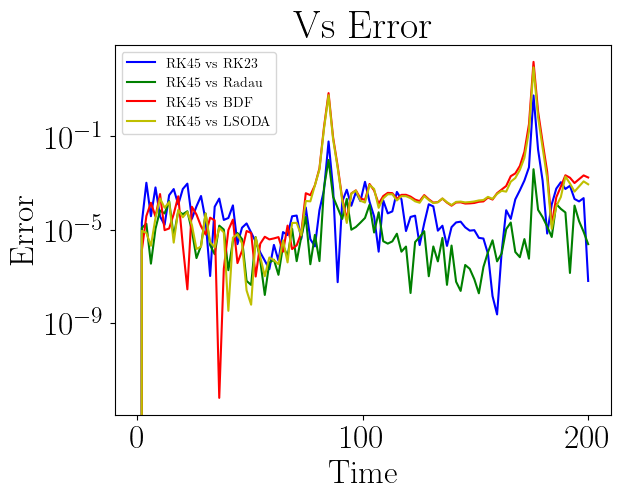

In [35]:
## Error between solution methods

print(len(rk45_sol.y[0,:]))
print(len(rk23_sol.y[0,:]))
print(len(radau_sol.y[0,:]))
print(len(BDF_sol.y[0,:]))
print(len(lsoda_sol.y[0,:]))
# V_s error
vs_rk45rk23_e = np.square(rk45_sol.y[0,:] - rk23_sol.y[0,:])
vs_rk45radau_e = np.square(rk45_sol.y[0,:] - radau_sol.y[0,:])
vs_rk45bdf_e = np.square(rk45_sol.y[0,:] - BDF_sol.y[0,:])
vs_rk45lsoda_e = np.square(rk45_sol.y[0,:] - lsoda_sol.y[0,:])


plt.plot(rk45_sol.t, vs_rk45rk23_e, 'b', label='Vs(t)')
plt.plot(rk45_sol.t, vs_rk45radau_e, 'g', label='Vs(t)')
plt.plot(rk45_sol.t, vs_rk45bdf_e, 'r', label='Vs(t)')
plt.plot(rk45_sol.t, vs_rk45lsoda_e, 'y', label='Vs(t)')
plt.yscale('log')
plt.title("Vs Error")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend(["RK45 vs RK23","RK45 vs Radau","RK45 vs BDF","RK45 vs LSODA"],fontsize=10)

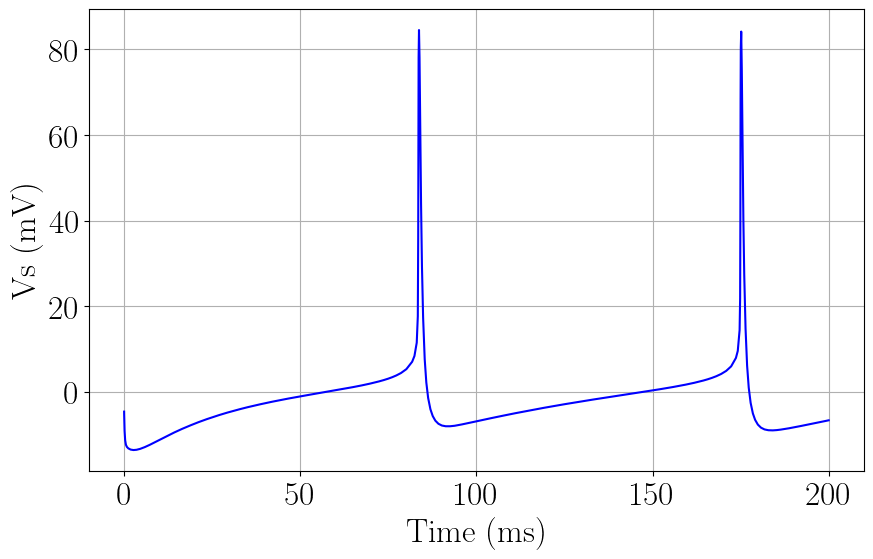

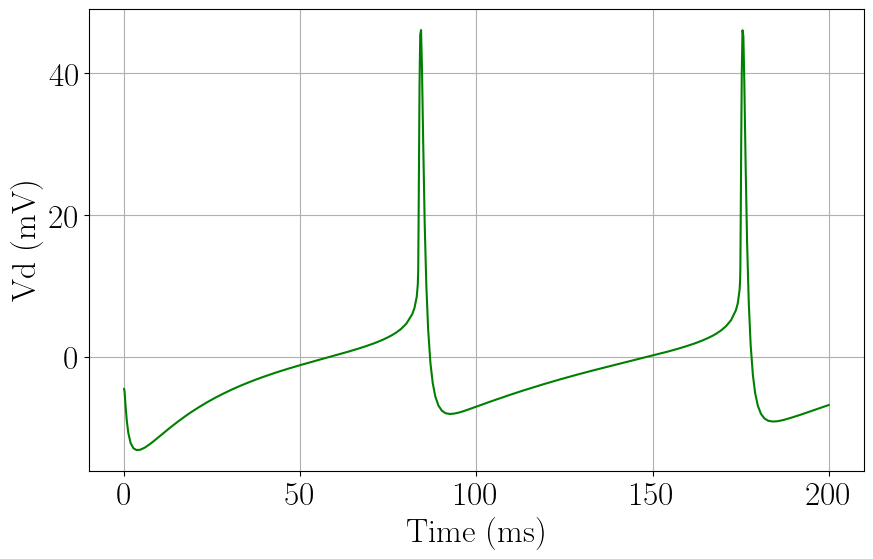

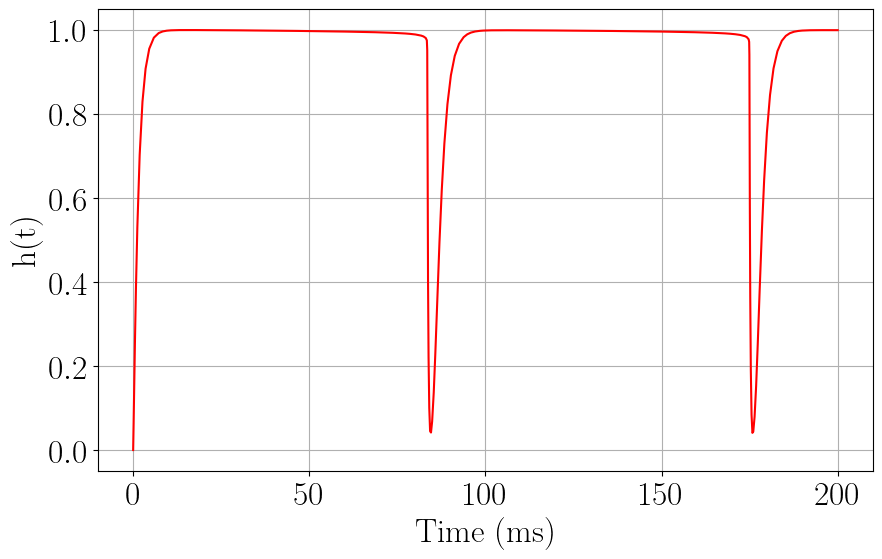

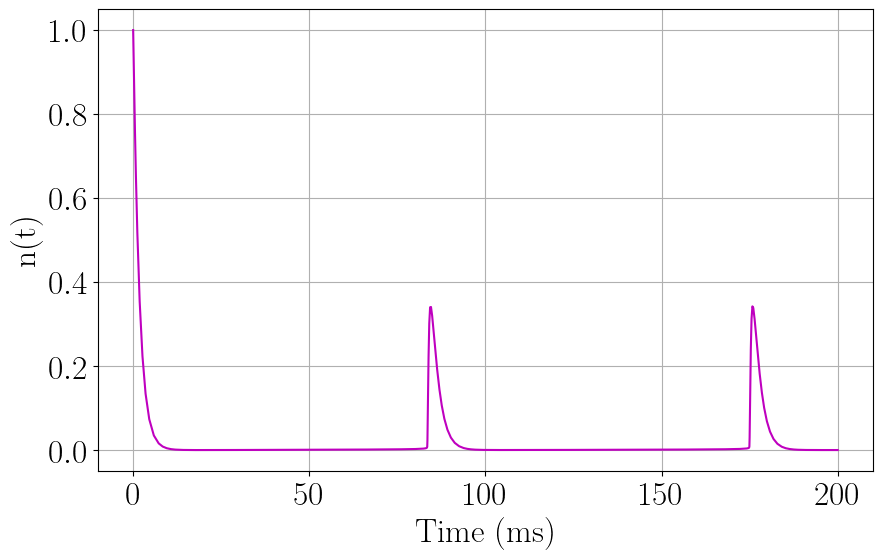

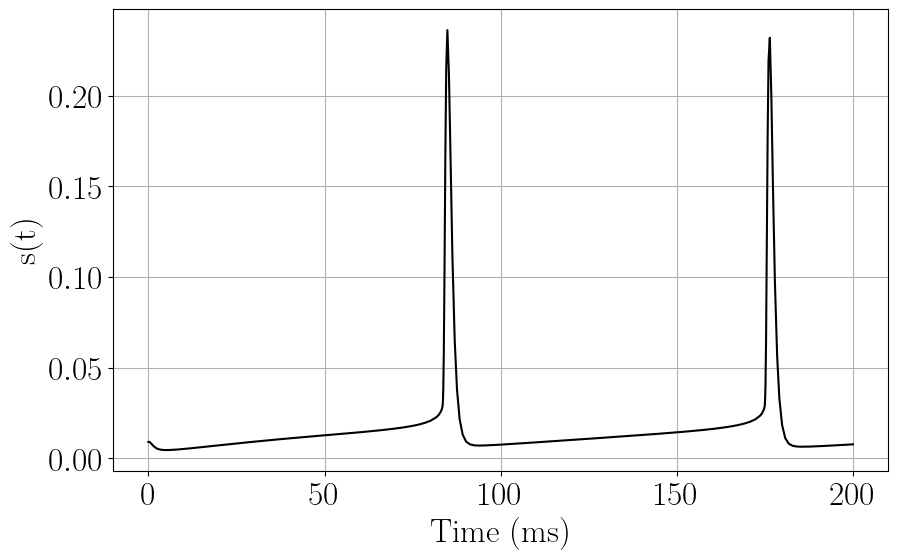

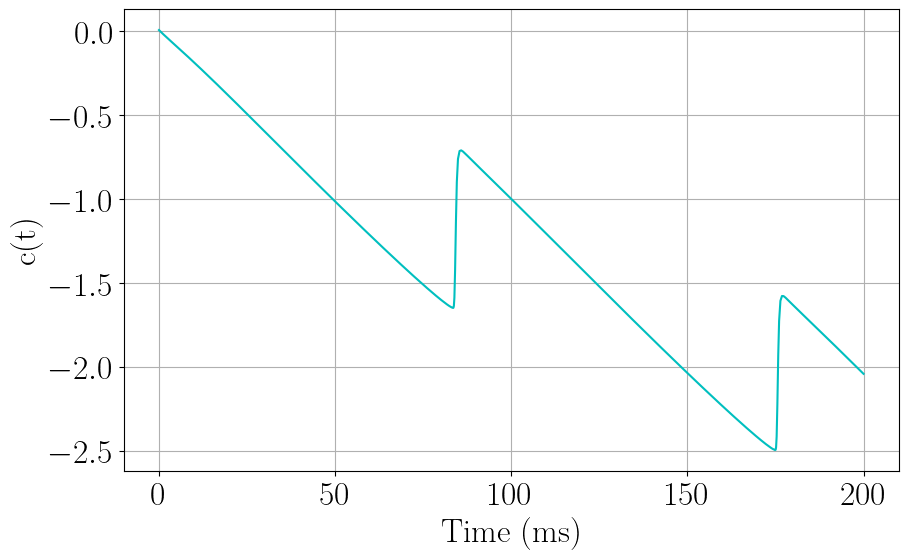

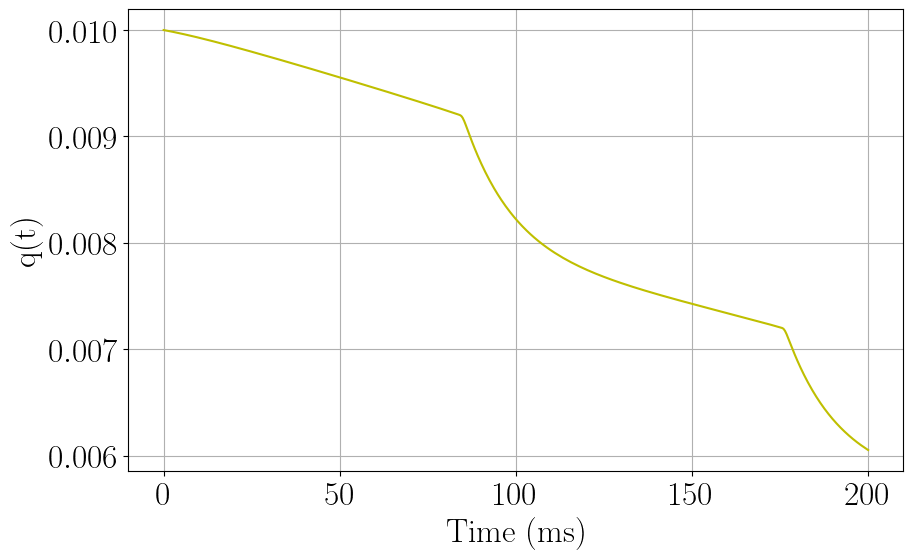

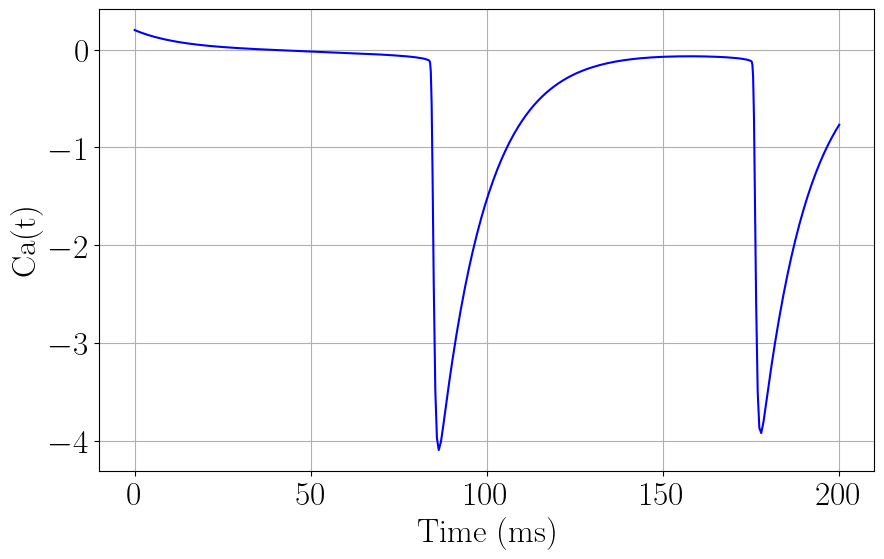

In [4]:
## Plotting


fig1 = plt.figure(figsize=(10,6))
#plt.subplot(1,3,1)
plt.plot(sol.t, sol.y[0, :], 'b', label='Vs(t)')
plt.ylabel('Vs (mV)')
plt.xlabel('Time (ms)')
plt.grid()
#plt.subplot(1,3,2)
fig2 = plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[1, :], 'g', label='Vd(t)')
plt.ylabel('Vd (mV)')
plt.xlabel('Time (ms)')
plt.grid()
#plt.subplot(1,3,3)
fig3 = plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[2, :], 'r', label='h(t)')
plt.ylabel('h(t)')
plt.xlabel('Time (ms)')
plt.grid()
fig4 = plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[3, :], 'm', label='n(t)')
plt.ylabel('n(t)')
plt.xlabel('Time (ms)')
plt.grid()
fig5 = plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[4, :], 'k', label='s(t)')
plt.ylabel('s(t)')
plt.xlabel('Time (ms)')
plt.grid()
fig6 = plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[5, :], 'c', label='c(t)')
plt.ylabel('c(t)')
plt.xlabel('Time (ms)')
plt.grid()
fig7 = plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[6, :], 'y', label='q(t)')
plt.ylabel('q(t)')
plt.xlabel('Time (ms)')
plt.grid()
fig8 = plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[7, :], 'b', label='Ca(t)')
plt.ylabel('Ca(t)')
plt.xlabel('Time (ms)')
plt.grid()
plt.show()